**Base Implementation with RotaryPositionalEmbeddings **

Attention used in RoPE

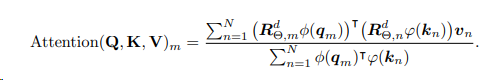


The inference time is higher than base implementation when we use RotaryPositionalEmbeddings.

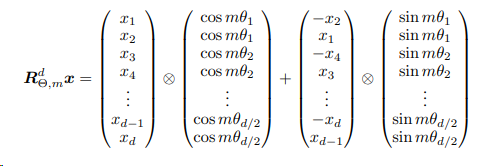

In [1]:
!pip install einops xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 678.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 783.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import torch.nn as nn
import torch
import copy
import math
import numpy as np
import torch.nn.functional as F

from torch.nn.parameter import Parameter
from torch.nn.modules import ModuleList
from dataclasses import dataclass

from torch import broadcast_tensors
from einops import rearrange, repeat
from einops import rearrange, repeat, pack, unpack
from torch import nn, einsum

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def broadcat(tensors, dim = -1):
    broadcasted_tensors = broadcast_tensors(*tensors)
    return torch.cat(broadcasted_tensors, dim = dim)

def rotate_half(x):
    '''The initial step of our roformer includes use of In order to generalize our results in 2D to any xi ∈ R
  d where d is even, we divide the d-dimension space into d/2
  sub-spaces and combine them in the merit of the linearity of the inner product, turning f{q,k} into
  The above was excerpt from paper which involves splitting into d/2'''
    x = rearrange(x, '... (d r) -> ... d r', r = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d r -> ... (d r)')

def apply_rotary_emb(freqs, t, start_index = 0, scale = 1., seq_dim = -2):
    '''a function for applying the rotatory embeddings frst getting the rotation dimension and sequence length
    getting the end index by adding the start index and rotation dimension as mentioned above,
    the t left, t and t right with the before token segment, during token segment and after token segment
    Applies the rotational embedding to the central portion of t.
    The rotation involves a combination of cosine and sine operations using the specified frequencies and scaling factor.  '''
    rot_dim, seq_len = freqs.shape[-1], t.shape[seq_dim]
    freqs = freqs[-seq_len:].to(t)
    end_index = start_index + rot_dim
    t_left, t, t_right = t[..., :start_index], t[..., start_index:end_index], t[..., end_index:]
    t = (t * freqs.cos() * scale) + (rotate_half(t) * freqs.sin() * scale)
    return torch.cat((t_left, t, t_right), dim = -1)

def apply_learned_rotations(rotations, t, start_index = 0, freq_ranges = None):
    '''Learning rotations by frequency handling by scaling out the rotations  this rearrangement helps in combining the rottations into one
    now repeating the rotations by replicating the rotations and then applying the rotatory embeddings'''
    if exists(freq_ranges):
        rotations = einsum('..., f -> ... f', rotations, freq_ranges)
        rotations = rearrange(rotations, '... r f -> ... (r f)')

    rotations = repeat(rotations, '... n -> ... (n r)', r = 2)
    return apply_rotary_emb(rotations, t, start_index = start_index)

In [5]:
class RotaryEmbedding(nn.Module):
    def __init__(
        self,
        dim,
        theta = 10000,
        max_freq = 10,
        num_freqs = 1,
        interpolate_factor = 1.,
        theta_rescale_factor = 1.,
    ):
        '''This is a constructor class for our rotatory embeddings
        theta: the angle for rotation
        max_freq:the max frequency for rotation
        num_freq:the number of times frequencies need to be iterated
        interpolate factor: A factor used to control the value of positional embedding if it is low or high
        theta_rescale_factor:As the theta decays with the learning so we need to rescale it for decaying
        '''
        super().__init__()
        theta *= theta_rescale_factor ** (dim / (dim - 2))


        freqs = 1. / (theta ** (torch.arange(0, dim, 2)[:(dim // 2)].float() / dim))

        self.cache = dict()
        self.cache_scale = dict()
        self.freqs = nn.Parameter(freqs)


        # default sequence dimension

        self.default_seq_dim = -2

        # interpolation factors

        assert interpolate_factor >= 1.
        self.interpolate_factor = interpolate_factor

        # xpos
        self.register_buffer('scale', None)


        scale = (torch.arange(0, dim, 2) + 0.4 * dim) / (1.4 * dim)
        self.register_buffer('scale', scale)

    def get_seq_pos(self, seq_len, device, dtype, offset = 0):
        '''
        The function to get the seq positonal embedding using torch.arange which uses [end-start]/start dividing by interpolation factor to control its value
         '''
        return (torch.arange(seq_len, device = device, dtype = dtype) + offset) / self.interpolate_factor

    def rotate_queries_or_keys(self, t, seq_dim = None, offset = 0, freq_seq_len = None):
        '''A function to operate the rotation over queries and keys'''
        seq_dim = default(seq_dim, self.default_seq_dim)


        device, dtype, seq_len = t.device, t.dtype, t.shape[seq_dim]#getting device, data type and sequence length

        if exists(freq_seq_len):
            assert freq_seq_len >= seq_len
            seq_len = freq_seq_len

        freqs = self.forward(lambda: self.get_seq_pos(seq_len, device = device, dtype = dtype, offset = offset), cache_key = f'freqs:{seq_len}|offset:{offset}')

        if seq_dim == -3:
            freqs = rearrange(freqs, 'n d -> n 1 d')

        return apply_rotary_emb(freqs, t, seq_dim = seq_dim)#applying the final operations over t value

    def forward(self, t, cache_key = None):
        '''The forward function for porpagting our t value'''
        should_cache = exists(cache_key)

        if should_cache and cache_key in self.cache:
            return self.cache[cache_key]

        if callable(t):
            t = t()

        freqs = self.freqs

        freqs = einsum('..., f -> ... f', t.type(freqs.dtype), freqs)# converting the frequency into its transpose
        freqs = repeat(freqs, '... n -> ... (n r)', r = 2)

        if should_cache:
            self.cache[cache_key] = freqs

        return freqs

In [6]:
class LayerNorm(nn.Module):

    def __init__(self, hidden_size, epsilon=1e-12):
      """
      Initialize LayerNorm module.
      """
      super().__init__()

      # Learnable weight parameter for scaling.
      self.weight = nn.Parameter(torch.ones(hidden_size))

      # Learnable bias parameter for shifting.
      self.bias = nn.Parameter(torch.zeros(hidden_size))

      # Small value to avoid division by zero in normalization.
      self.epsilon = epsilon

    def forward(self, x):

      # Compute mean and variance along the last dimension.
      u = x.mean(-1, keepdim=True)
      s = (x - u).pow(2).mean(-1, keepdim=True)

      # Normalize the input tensor.
      x = (x - u) / torch.sqrt(s + self.epsilon)

      # Scale and shift using learnable parameters.
      return self.weight * x + self.bias

In [7]:
class Conv1D(nn.Module):
    def __init__(self, nx, nf):
        '''
        The CONV 1D layer can be thought of as a linear layer itself.
        It is casting an initial tensor x (having the final
        dimension of x.size(-1)) being passed to it to have a final dimension
        of size self.nf.

        We do this to be able to cast the input to query, key and value matrices.

        nx: Number of input features.
        nf: Number of filters (output channels).
        '''
        super().__init__()
        self.nf = nf
        #intialising an empty matrix as weights for size of (nx)X(nf)
        w = torch.empty(nx, nf)
        #initialising these weights as normal distribution
        nn.init.normal_(w, std=0.02)
        #calculating the weights and biases by encoding them using nn.Parameter
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        '''x:The input tensor'''
        #this size output is summation of x second dimension and the nf dimension
        size_out = x.size()[:-1] + (self.nf,)
        # dot multiplying Q,K(transpose) and V
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        #x.view helps in taking the transpose out
        x = x.view(*size_out)
        return x

In [8]:
class FeedForward(nn.Module):
    def __init__(self, dropout, d_model=768, nx=768*4):
        super().__init__()
        self.c_fc    = Conv1D(d_model, nx)
        self.c_proj  = Conv1D(nx, d_model)
        self.act     = F.gelu
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

In [9]:
class MultiHeadAttention_withmodifications(nn.Module):
    def __init__(self, d_model=768, n_head=12, n_ctx=1024, d_head=64, bias=True, scale=False):
        '''Constructor funtion
        Params:
        d_model:The dimension that needs to be feed into our model
        n_head:The number of heads for attention
        n_ctx:a parameters for buffer registry for bias
        d_head:the dimension head output
        bias:A bool for including or not including bias
        scale: Whether to scale the attention scores by the square root of the dimension of the queries(use sqrt(dk) or not) "
        '''
        super().__init__()
        self.n_head  = n_head
        self.d_model = d_model
        self.c_attn  = Conv1D(d_model, d_model*3)
        self.scale   = scale
        self.softmax = nn.Softmax(dim=-1)
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.dropout = nn.Dropout(0.1)
        self.c_proj  = Conv1D(d_model, d_model)
        # additional
        #intializing the rotatory embedding with dimension 32
        self.rotary_emb = RotaryEmbedding(dim = 32)

    def split_heads(self, x):
        """
        spliting inyo given number of heads and then returning
        return shape [`batch`, `head`, `sequence`, `features`]
        """
        new_shape = x.size()[:-1] + (self.n_head, x.size(-1)//self.n_head)
        x = x.view(*new_shape)
        return x.permute(0, 2, 1, 3)

    def _attn(self, q, k, v, attn_mask=None):
        """The main attention function
        That claculates the attention using our dot product formula"""
        scores  = torch.matmul(q, k.transpose(-2, -1))# dot multiplication between q and k transpose
        if self.scale: scores = scores/math.sqrt(v.size(-1))# scaling it by dividing by sqrt(dk)
        nd, ns  = scores.size(-2), scores.size(-1)
        if attn_mask is not None: scores = scores + attn_mask# adding scores with attention mask values
        scores  = self.softmax(scores)# adding softmax values
        scores  = self.dropout(scores) #dropout of 0.1 as mentioned
        outputs = torch.matmul(scores, v) # now the final matrix multiplication between score and V
        return outputs

    def merge_heads(self, x):
        # merging the attention heads into one
        x = x.permute(0, 2, 1, 3).contiguous()
        new_shape = x.size()[:-2] + (x.size(-2)*x.size(-1),)
        return x.view(*new_shape)

    def forward(self, x):
        '''The feed forward function that calculates the attention, split the heads, make attention, merge heads and project out the output '''
        x        = self.c_attn(x) #new `x` shape - `[1,3,2304]`
        q, k, v  = x.split(self.d_model, dim=2)
        q, k, v  = self.split_heads(q), self.split_heads(k), self.split_heads(v)
        # additional
        #applying the rotatory embeddings over query and key
        q = self.rotary_emb.rotate_queries_or_keys(q)
        k = self.rotary_emb.rotate_queries_or_keys(k)
        out      = self._attn(q, k, v)
        out      = self.merge_heads(out)
        out      = self.c_proj(out)
        return out

In [10]:
def _get_clones(module, n):
    '''Here we can make certain copies of transformers'''
    return ModuleList([copy.deepcopy(module) for i in range(n)])

In [11]:
class TransformerBlock_RotaryEmbedding(nn.Module):
    def __init__(self, d_model=768, n_head=12, dropout=0.1):
        super().__init__()
        self.attn        = MultiHeadAttention_withmodifications(d_model=768, n_head=12, d_head=64, n_ctx=1024, bias=True, scale=False)
        self.feedforward = FeedForward(dropout=0.1, d_model=768, nx=768*4)
        self.ln_1        = LayerNorm(d_model)
        self.ln_2        = LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.feedforward(self.ln_2(x))
        return x

In [12]:

class GPT2_RotaryEmbedding(nn.Module):
    def __init__(self, nlayers=12, n_ctx=1024, d_model=768, vcb_sz=50257):
        super(GPT2_RotaryEmbedding, self).__init__()
        self.nlayers = nlayers
        block        = TransformerBlock_RotaryEmbedding(d_model=768, n_head=12, dropout=0.1)
        self.h       = _get_clones(block, 12)
        self.wte     = nn.Embedding(vcb_sz, d_model)
        self.wpe     = nn.Embedding(n_ctx, d_model)
        self.drop    = nn.Dropout(0.1)
        self.ln_f    = LayerNorm(d_model)
        self.out     = nn.Linear(d_model, vcb_sz, bias=False)
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_weights()

    def init_weights(self):
        '''Initialization of weights'''
        self.out.weight = self.wte.weight
        self.apply(self._init_weights)

    def _init_weights(self, module):
        '''If the Linear, Embedding and Conv1D then nomrally initializing with mean and S.D'''
        if isinstance(module, (nn.Linear, nn.Embedding, Conv1D)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, (nn.Linear, Conv1D)) and module.bias is not None:
                '''Data Bias zero'''
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, src, labels=None, pos_ids=None):
        '''Adding the positional embedding, dropping, then adding inputs, logits and outputs which are being used for loss function and then adding outputs and loss'''
        if pos_ids is None: pos_ids = torch.arange(0, src.size(-1)).unsqueeze(0)
        inp = self.drop((self.wte(src)+self.wpe(pos_ids)))
        for i in range(self.nlayers): inp = self.h[i](inp)
        inp     = self.ln_f(inp)
        logits  = self.out(inp)
        outputs = (logits,) + (inp,)

        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss = self.loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            outputs = (loss,) + outputs
            return outputs
        return logits

**Generating text and checking model stats**

In [13]:
# load pretrained_weights from hugging face
# download file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin to `.`

!wget https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin .

--2023-12-17 15:40:10--  https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.162.152, 52.217.164.224, 54.231.196.16, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.162.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 548118077 (523M) [application/octet-stream]
Saving to: ‘gpt2-pytorch_model.bin’

gpt2-pytorch_model. 100%[===================>] 522.73M  60.3MB/s    in 8.9s    

2023-12-17 15:40:19 (58.7 MB/s) - ‘gpt2-pytorch_model.bin’ saved [548118077/548118077]

--2023-12-17 15:40:19--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-12-17 15:40:19--
Total wall clock time: 9.2s
Downloaded: 1 files, 523M in 8.9s (58.7 MB/s)


In [14]:
model = GPT2_RotaryEmbedding()
# load pretrained_weights from hugging face

model_dict = model.state_dict() #currently with random initialization
state_dict = torch.load("/content/gpt2-pytorch_model.bin") #pretrained weights
old_keys = []
new_keys = []
for key in state_dict.keys():
    if "mlp" in key: #The hugging face state dict references the feedforward network as mlp, need to replace to `feedforward` be able to reuse these weights
        new_key = key.replace("mlp", "feedforward")
        new_keys.append(new_key)
        old_keys.append(key)

for old_key, new_key in zip(old_keys, new_keys):
    state_dict[new_key]=state_dict.pop(old_key)

pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict}

model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.eval() #model in inference mode as it's now initialized with pretrained weights

GPT2_RotaryEmbedding(
  (h): ModuleList(
    (0-11): 12 x TransformerBlock_RotaryEmbedding(
      (attn): MultiHeadAttention_withmodifications(
        (c_attn): Conv1D()
        (softmax): Softmax(dim=-1)
        (dropout): Dropout(p=0.1, inplace=False)
        (c_proj): Conv1D()
        (rotary_emb): RotaryEmbedding()
      )
      (feedforward): FeedForward(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_1): LayerNorm()
      (ln_2): LayerNorm()
    )
  )
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (ln_f): LayerNorm()
  (out): Linear(in_features=768, out_features=50257, bias=False)
  (loss_fn): CrossEntropyLoss()
)

In [15]:
total_params = sum(p.numel() for p in model.parameters())

# Calculate size in bytes and megabytes
size_bytes = total_params * 4  # Assuming float32 parameters, where each parameter is 4 bytes
size_mb = size_bytes / (1024 ** 2)

print(f"Total size of the GPT-2 with rotary embeddings any is: {size_bytes} bytes or {size_mb:.2f} MB")

Total size of the GPT-2 with rotary embeddings any is: 497760000 bytes or 474.70 MB


In [16]:
import time
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
context = torch.tensor([tokenizer.encode("Hi Contlo, How")])

def generate(context, ntok=20):
    start_time = time.time()
    for _ in range(ntok):
        out = model(context)
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    end_time = time.time()
    inference_time = end_time - start_time
    return context, inference_time

out, inference_time = generate(context, ntok=20)
decoded_output = tokenizer.decode(out[0])

print(f"Inference Time: {inference_time:.4f} seconds")
print(f"Generated Output: {decoded_output}")


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Inference Time: 4.4710 seconds
Generated Output: Hi Contlo, How do not. More.ent. You know not is (No. ( You Lo. The Best
